In [ ]:
# local
#import os
#ROOT = os.path.abspath('')

In [ ]:
# Colab Drive
from google.colab import drive
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/Colab Notebooks/Tache SemEval/Projet_SemEval2023_ATAL/'

Mounted at /content/drive


In [ ]:
%pip install transformers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


In [ ]:
import torch, os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding


import spacy
import re
import json

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EvalPrediction

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Chargement Data:

In [ ]:
train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/train.csv'))
valid_df = pd.read_csv(os.path.join(ROOT, 'BUILD/dev.csv'))
test_df = pd.read_csv(os.path.join(ROOT, 'BUILD/test.csv'))
extended_train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/extended_train_dataset.csv'))

<ipython-input-6-95120531d619>:4: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  extended_train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/extended_train_dataset.csv'))


In [ ]:
#extended_train_df.shape


(200020, 9)

In [ ]:
#train_df.shape

(26087, 9)

#### Dataset augmenté

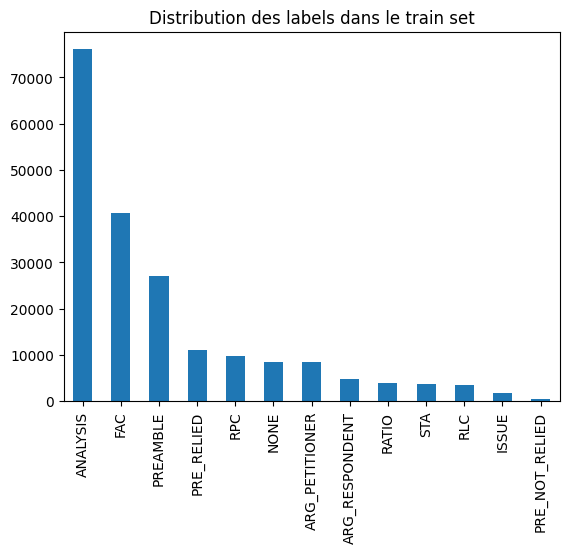

In [ ]:
extended_train_df["labels"].value_counts().plot(kind='bar')
plt.title('Distribution des labels dans le train set')
plt.show()


In [ ]:
#compter la distribution des labels dans le test set
extended_train_df["labels"].value_counts()

ANALYSIS          76077
FAC               40626
PREAMBLE          26977
PRE_RELIED        11184
RPC                9862
NONE               8453
ARG_PETITIONER     8385
ARG_RESPONDENT     4849
RATIO              3919
STA                3734
RLC                3589
ISSUE              1811
PRE_NOT_RELIED      554
Name: labels, dtype: int64

Mapage des labels:

In [ ]:
rr_labels = [
    'PREAMBLE',
    'FAC',
    'RLC',
    'ISSUE',
    'ARG_PETITIONER',
    'ARG_RESPONDENT',
    'ANALYSIS',
    'STA',
    'PRE_RELIED',
    'PRE_NOT_RELIED',
    'RATIO',
    'RPC',
    'NONE'
]
MAP_LABEL = {k: i for i, k in enumerate(rr_labels)}
print(MAP_LABEL)

{'PREAMBLE': 0, 'FAC': 1, 'RLC': 2, 'ISSUE': 3, 'ARG_PETITIONER': 4, 'ARG_RESPONDENT': 5, 'ANALYSIS': 6, 'STA': 7, 'PRE_RELIED': 8, 'PRE_NOT_RELIED': 9, 'RATIO': 10, 'RPC': 11, 'NONE': 12}


In [ ]:
train_df["labels_class"] = train_df['labels'].apply(lambda x: MAP_LABEL[x])
valid_df["labels_class"] = valid_df['labels'].apply(lambda x: MAP_LABEL[x])


Distribution des classes:

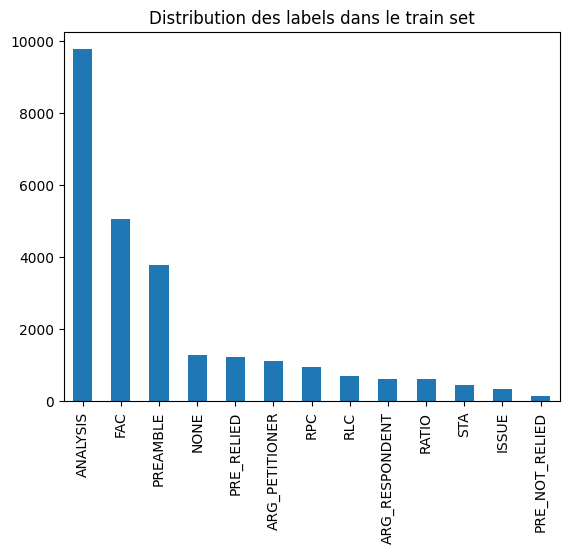

In [ ]:
train_df["labels"].value_counts().plot(kind='bar')
plt.title('Distribution des labels dans le train set')
plt.show()

In [ ]:
#compter la distribution des labels dans le test set
train_df["labels"].value_counts()

ANALYSIS          9765
FAC               5070
PREAMBLE          3778
NONE              1286
PRE_RELIED        1221
ARG_PETITIONER    1120
RPC                954
RLC                711
ARG_RESPONDENT     620
RATIO              619
STA                443
ISSUE              344
PRE_NOT_RELIED     156
Name: labels, dtype: int64

### Création d'un dataset avec du random over-sampling de la classe minoritaire:

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Initialiser l'échantillonneur aléatoire
ros = RandomOverSampler(random_state=42)

# Données sous forme de X (features) et y (labels) pour RandomOverSampler.
# Dans ce cas, X pourrait être juste un ensemble de numéros de ligne, car nous n'utilisons pas vraiment les données pour le suréchantillonnage.
X = train_df.index.values.reshape(-1, 1)
y = train_df["labels"].values

X_resampled, y_resampled = ros.fit_resample(X, y)

# Créer un nouveau DataFrame à partir des indices suréchantillonnés
Random_Over_Sample_train_df = train_df.loc[X_resampled.flatten()]

# Vérifiez le nouvel équilibre des classes
print(Random_Over_Sample_train_df["labels"].value_counts())


PREAMBLE          9765
NONE              9765
FAC               9765
ARG_RESPONDENT    9765
RLC               9765
ARG_PETITIONER    9765
ANALYSIS          9765
PRE_RELIED        9765
RATIO             9765
RPC               9765
ISSUE             9765
STA               9765
PRE_NOT_RELIED    9765
Name: labels, dtype: int64


#### Sample du ROS train set

In [ ]:
Random_Over_Sample_train_df_Sample = Random_Over_Sample_train_df.sample(frac=0.2, random_state=42) #0.2 = 25389

In [ ]:
print(Random_Over_Sample_train_df_Sample["labels"].value_counts())

ARG_RESPONDENT    2014
ARG_PETITIONER    2006
NONE              1997
RATIO             1983
RPC               1965
PREAMBLE          1963
PRE_NOT_RELIED    1961
ISSUE             1954
ANALYSIS          1940
FAC               1940
STA               1931
PRE_RELIED        1869
RLC               1866
Name: labels, dtype: int64


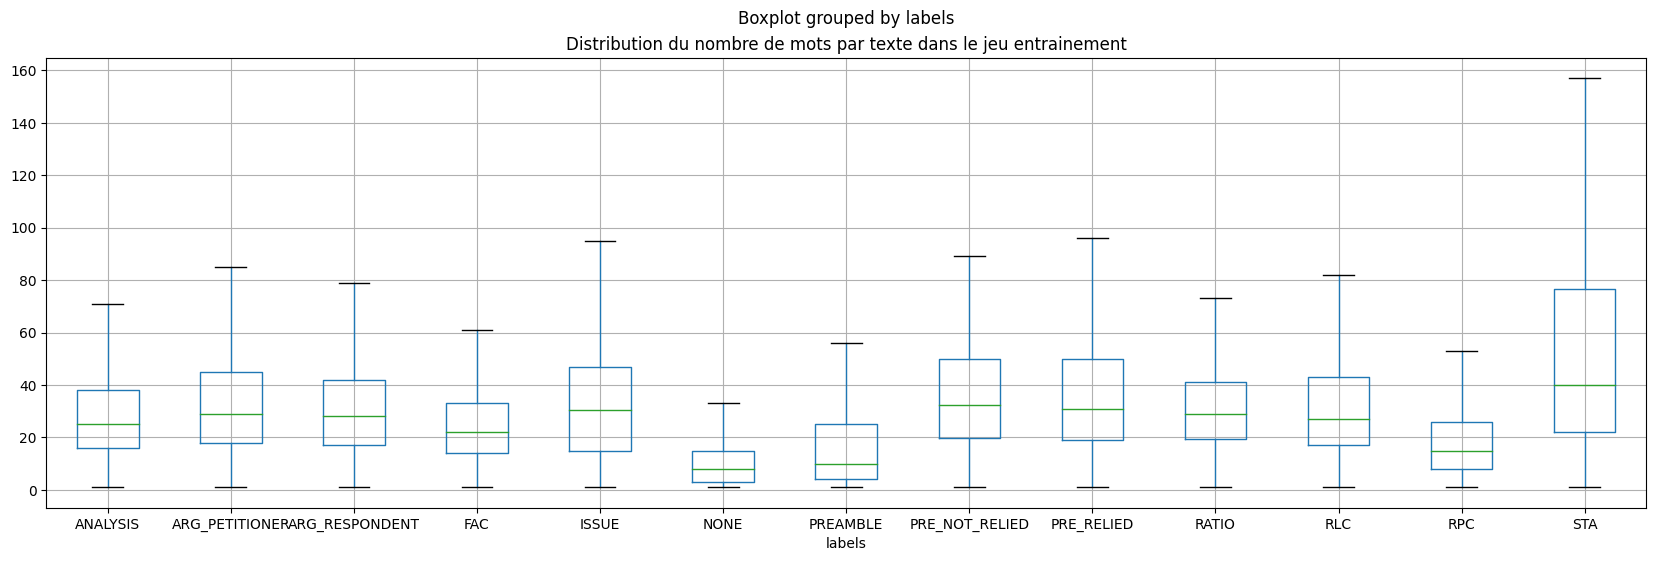

In [ ]:
#estimation de la longueur des textes
train_df['mots_par_texte'] = train_df['text'].apply(lambda x: len(x.split()))
train_df.boxplot(column='mots_par_texte', by='labels', figsize=(20, 6), showfliers=False)
plt.title('Distribution du nombre de mots par texte dans le jeu entrainement')
plt.show()

## Transformers

In [ ]:
# Charger le modèle

def load_model(path, device, **kwargs):
    model = AutoModelForSequenceClassification.from_pretrained(path, **kwargs)
    model = model.to(device)
    return model

def load_tokenizer(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    return tokenizer

In [ ]:
# Charger le modèle anglais de spaCy si besoin de preprocessing des textes
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Pretraitement des donnees
def _preprocess(text: str) -> str:
    # To clean the text, replace tokens, ...

    # Supprimer les caractères spéciaux et les espaces superflus
    text = re.sub(r'\s+', ' ', text.replace('\n', ' '))

    # Convertir le texte en minuscules
    text = text.lower()

    # Traitement avec spaCy
    doc = nlp(text)

    # Supprimer les stop words et faire de la lemmatisation
    cleaned_text = ' '.join(token.lemma_ for token in doc if not token.is_stop)

    # Retourner le texte nettoyé
    return cleaned_text

In [ ]:
class BUILDDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, device, include_labels=True):
        self.ids = df.index.tolist()
        self.encodings = tokenizer(
            df['text'].tolist(),
            truncation=True,
            padding=False,
            max_length=512
        )
        self.include_labels = include_labels
        if include_labels and 'labels_class' in df:
            self.labels = df['labels_class'].tolist()
        else:
            self.labels = [0] * len(df)  # Utilisez une étiquette par défaut, par ex. 0

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.include_labels:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


Evaluation:

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Tokenization:

In [ ]:
tokenizer = load_tokenizer("nlpaueb/legal-bert-small-uncased")
model = load_model("nlpaueb/legal-bert-small-uncased", device, num_labels=len(rr_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/989 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(rr_labels))
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(rr_labels))

#### Padding Dynamique

In [ ]:
# Créer une instance de DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

#### Création des datasets

In [ ]:
#train_dataset = BUILDDataset(train_df, tokenizer, device)
valid_dataset = BUILDDataset(valid_df, tokenizer, device)

In [ ]:
ROS_train_dataset = BUILDDataset(Random_Over_Sample_train_df, tokenizer, device)

In [ ]:
extended_train_dataset = BUILDDataset(extended_train_df, tokenizer, device)

In [ ]:
#train_dataset.__getitem__(0)

Configuration du modèle:

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,             # total number of training epochs
    #max_steps=500,                    # trains for 10 batches
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='epoch', # evaluer à chaque epoch
    save_strategy='epoch', # sauvegarder à chaque epoch
    #report_to="tensorboard",  # Ajoutez cette ligne pour utiliser TensorBoard
    learning_rate=1e-4, # taux d'apprentissage 5e-4, 1e-4(legal bert training)
)

trainer = Trainer(
    model=model.to(device),                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=extended_train_dataset,         # training dataset
    eval_dataset=valid_dataset,             # evaluation dataset
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.648600,1.198194,0.645395,0.636666,0.658216,0.645395
2,0.389600,1.351317,0.645050,0.639867,0.650613,0.645050


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=12502, training_loss=0.622873600836354, metrics={'train_runtime': 2944.5488, 'train_samples_per_second': 135.858, 'train_steps_per_second': 4.246, 'total_flos': 8159570724270024.0, 'train_loss': 0.622873600836354, 'epoch': 2.0})

Inférence et évaluation:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Faites les prédictions sur les données de validation
predictions = trainer.predict(valid_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Obtenez les étiquettes prédites et les vraies étiquettes
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = valid_dataset.labels


In [ ]:
# Calculez les scores de précision, de rappel et de f-mesure
report = classification_report(true_labels, predicted_labels, target_names=rr_labels, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Afficher le rapport dans un DataFrame
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
PREAMBLE,0.873626,0.817481,0.844622,389.00000
FAC,0.622003,0.654303,0.637744,674.00000
RLC,0.400000,0.634146,0.490566,41.00000
ISSUE,0.714286,0.869565,0.784314,23.00000
ARG_PETITIONER,0.587302,0.379487,0.461059,195.00000
ARG_RESPONDENT,0.536585,0.282051,0.369748,78.00000
ANALYSIS,0.589319,0.688172,0.634921,930.00000
STA,0.553191,0.684211,0.611765,38.00000
PRE_RELIED,0.684211,0.371429,0.481481,210.00000
PRE_NOT_RELIED,0.000000,0.000000,0.000000,2.00000


In [ ]:
# Sauvegarder le modèle
model_save_path = os.path.join(ROOT, 'Model/Model')
model.save_pretrained(model_save_path)

# Sauvegarder le tokenizer
tokenizer_save_path = os.path.join(ROOT, 'Model/Tokenizer')
tokenizer.save_pretrained(tokenizer_save_path)


KeyboardInterrupt: 

Matrice de confusion:

In [ ]:
# Calculer la matrice de confusion
confusion = confusion_matrix(true_labels, predicted_labels)

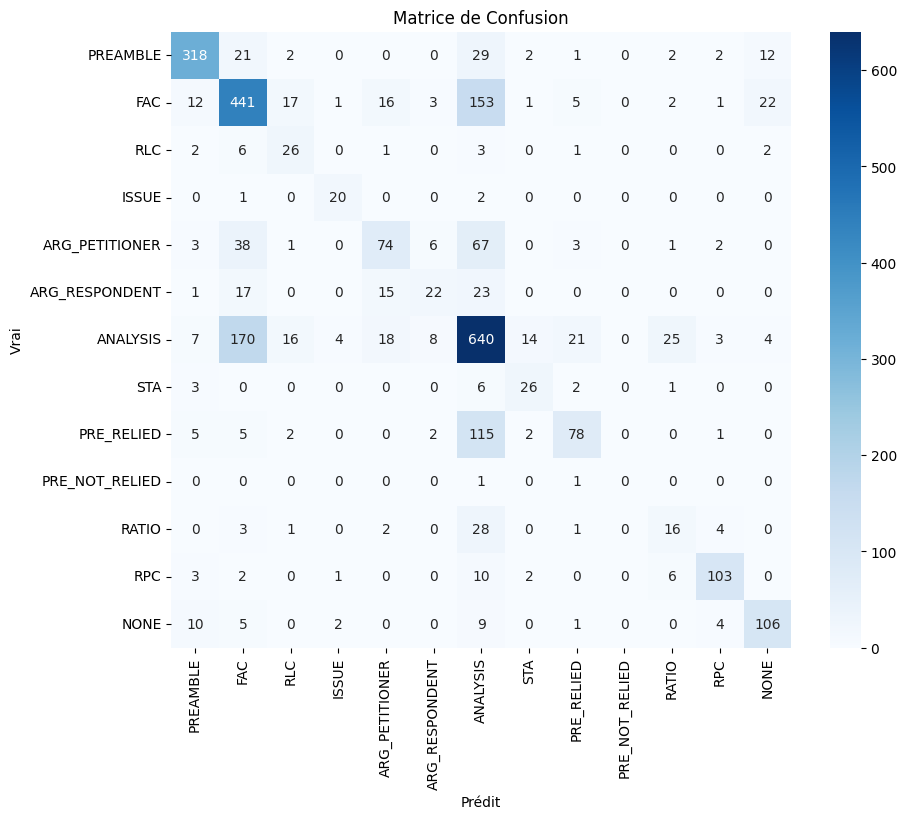

In [ ]:
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=rr_labels, yticklabels=rr_labels)
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
#afficher dans un dataframe pandas la matrice de confusion
df_confusion = pd.DataFrame(confusion, index=rr_labels, columns=rr_labels)

### Analyse d'erreur

In [ ]:
# Faire des prédictions sur les données de validation
predictions = trainer.predict(valid_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Obtenir les vraies étiquettes
true_labels = [valid_dataset[i]['labels'] for i in range(len(valid_dataset))]

# Trouver les indices des erreurs de classification
mismatched_indices = np.where(preds != true_labels)[0]

# Récupérer les exemples mal classifiés
misclassified_examples = [valid_dataset[i] for i in mismatched_indices]

# Fonction pour décodifier les tokens en texte
def decode_tokens(token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True)

# Afficher les exemples mal classifiés avec leurs prédictions et les vrais labels
for i in mismatched_indices[:5]:  # Limitez le nombre d'exemples à afficher
    text = decode_tokens(valid_dataset[i]['input_ids'])
    print(f"Text: {text}")
    print(f"Predicted label: {rr_labels[preds[i]]}")
    print(f"True label: {rr_labels[true_labels[i]]}")
    print("\n")


# Amélioration de la méthode transformer

Utilisation de données externes (self-learning)
1. Récolter des documents similaires non annotés --> utilisation d'un dataset tiré de indianKanoon dispo sur Kaggle (mise en forme avec la baseline proposée par legalEval)
2. Appliquer la prédiction d’un modèle --> utilsation du transformer pour la prediction
3. Choisir les prédictions les plus sûres
4. Ajouter les documents et leur annotation au corpus d’entraînement
5. Affiner le modèle

#### Charger le modèle et le tokenizer sauvegardés :

In [ ]:
# Charger le modèle sauvegardé
best_model = load_model( os.path.join(ROOT, 'Model/Model'), device)
# Charger le tokenizer sauvegardé
best_tokenizer = load_tokenizer( os.path.join(ROOT, 'Model/Tokenizer'))


#### Préparer le dataset pour la prédiction :

In [ ]:
# Charger les données JSON
with open(os.path.join(ROOT, 'BUILD/case_processed_5000.json'), 'r') as file:
    new_data_json = json.load(file)

# Convertir en DataFrame
new_data_df = pd.DataFrame(new_data_json)
#new_data_df.rename(columns={'text': 'data'}, inplace=True)

# Créer un dataset pour la prédiction
predict_dataset = BUILDDataset(new_data_df, best_tokenizer, device, include_labels=False)

In [ ]:
#new_data_df.head(2)

#### Faire des prédictions :

In [ ]:
# Créer une instance de DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=best_tokenizer, return_tensors="pt")

# Préparer l'objet Trainer pour la prédiction avec le DataCollator
predictor = Trainer(
    model=best_model.to(device),
    data_collator=data_collator)

In [ ]:
# Faire des prédictions
new_predictions = predictor.predict(predict_dataset)
new_preds = np.argmax(new_predictions.predictions, axis=1)

#### Sélectionner les prédictions les plus sûres et les ajouter au corpus d'entraînement :

In [ ]:
seuil_confiance = 0.9  # Ajuster ce seuil au besoin
high_confidence_indices = np.where(new_predictions.predictions.max(axis=1) > seuil_confiance)[0]
high_confidence_data = new_data_df.iloc[high_confidence_indices]
high_confidence_labels = [rr_labels[pred] for pred in new_preds[high_confidence_indices]]
high_confidence_data['labels'] = high_confidence_labels

# Concaténer avec l'ensemble d'entraînement existant
extended_train_df = pd.concat([train_df, high_confidence_data])
extended_train_df['labels_class'] = extended_train_df['labels'].apply(lambda x: MAP_LABEL.get(x, x))
extended_train_dataset = BUILDDataset(extended_train_df, best_tokenizer, device)